**Get Images out of Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""import zipfile
import os

def unzip_file(zip_filepath, extract_to_dir):
    """
    Unzips a zip file to the specified directory.

    :param zip_filepath: Path to the zip file
    :param extract_to_dir: Directory where the files should be extracted
    """
    # Ensure the extraction directory exists
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)

    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
        print(f"Extracted all files to {extract_to_dir}")

# Example usage
zip_filepath = '/content/drive/MyDrive/Augmentated_Images.zip'
extract_to_dir = '/content/Training_Images'
unzip_file(zip_filepath, extract_to_dir)

"""

Extracted all files to /content/Training_Images


In [ ]:
"""import os

def count_images_in_folder(folder_path):
    # List all files in the directory
    files = os.listdir(folder_path)

    # Filter out files that are not images
    image_files = [file for file in files if file.endswith(('.jpg'))]

    # Count the number of image files
    number_of_images = len(image_files)

    return number_of_images

# Example usage
augmented_images_folder = '/content/Training_Images'
number_of_images = count_images_in_folder(augmented_images_folder)
print(f"Number of images in the augmented images folder: {number_of_images}")
"""

Number of images in the augmented images folder: 13527


**Image Segmentation**

Prominent Smoke Area in Images, Using the Concept of ROIs

In [ ]:
"""import cv2
import numpy as np
import os

def highlight_and_extract_blue_bounded_boxes(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the blue color
    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])

    # Create a mask to isolate the blue color
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding rectangles around the blue bounded boxes
    blue_boxes_found = False
    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # Only consider contours with a certain area (to filter out noise)
        if area > 1000:  # Adjust this threshold as needed
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            blue_boxes_found = True

    return blue_boxes_found, image

def extract_and_highlight_images_with_rois(input_folder, output_folder):
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over the images in the input folder
    for filename in os.listdir(input_folder):
        # Read the image
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        # Highlight blue bounded boxes and check if any blue bounded boxes are found
        blue_boxes_found, highlighted_image = highlight_and_extract_blue_bounded_boxes(image)

        # Save the image only if blue bounded boxes are found
        if blue_boxes_found:
            output_image_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_image_path, highlighted_image)

# Specify the input and output folders
input_folder = '/content/Training_Images'
output_folder = '/content/Training_Data'

# Perform extraction and highlight blue bounded boxes
extract_and_highlight_images_with_rois(input_folder, output_folder)
"""

In [ ]:
"""
ROIs_images_folder = '/content/Training_Data'
number_of_images = count_images_in_folder(ROIs_images_folder)
print(f"Number of images in the ROIs images folder: {number_of_images}")
"""

Number of images in the ROIs images folder: 9574


**Zip the Training_Data**

In [ ]:
"""import os
import zipfile

def zip_folder(folder_path, output_path):

    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=folder_path)
                zipf.write(file_path, arcname)

# Example usage:
folder_to_zip = '/content/Training_Data'
output_zip_file = '/content/drive/MyDrive/Training_Data_Image_Segmentation.zip'

zip_folder(folder_to_zip, output_zip_file)
"""

**Model Creation**

In [ ]:
"""import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Function to identify images with highlighted blue bounded boxes
def identify_images_with_blue_bounded_boxes(dataset_folder):
    identified_images = []
    for filename in os.listdir(dataset_folder):
        # Read the image
        image = cv2.imread(os.path.join(dataset_folder, filename))

        # Convert the image to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define the lower and upper bounds for the blue color
        lower_blue = np.array([100, 150, 0])
        upper_blue = np.array([140, 255, 255])

        # Create a mask to isolate the blue color
        mask = cv2.inRange(hsv, lower_blue, upper_blue)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Check if any blue bounded boxes are found
        blue_boxes_found = False
        for contour in contours:
            # Calculate the area of the contour
            area = cv2.contourArea(contour)

            # Only consider contours with a certain area (to filter out noise)
            if area > 1000:  # Adjust this threshold as needed
                blue_boxes_found = True
                break

        # Add identified images to the list
        if blue_boxes_found:
            identified_images.append(filename)

    return identified_images

# Split the dataset into training and testing sets
def split_dataset(images):
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    return train_images, test_images

# Define SegNet architecture for pixel segmentation
def SegNet(input_shape, num_classes):
    # Define encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Define decoder
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    up1 = UpSampling2D((2, 2))(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv4)
    outputs = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(up2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Load and preprocess the dataset, perform pixel segmentation using SegNet, classify highlighted portions, train the model, and save it
from tensorflow.keras.callbacks import ModelCheckpoint

# Train and save the model
def train_and_save_model(train_images):
    # Load and preprocess the dataset...
    # Define input shape
    input_shape = (height, width, channels)

    # Define number of classes (Less Smoke, High Smoke)
    num_classes = 2

    # Define SegNet model for pixel segmentation
    model = SegNet(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    checkpoint = ModelCheckpoint("Smoke_Pixel_Segmentation.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs, batch_size=batch_size, callbacks=[checkpoint])


import cv2
import numpy as np

# Provide prediction function
def predict_image(image_path, model):
    # Load the saved model
    model = load_model(model)

    # Preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))  # Resize the image to match the input shape
    image = image / 255.0  # Normalize the image

    # Perform pixel segmentation using SegNet
    segmentation = model.predict(np.expand_dims(image, axis=0))

    # Classify highlighted portion
    highlighted_pixels = np.argmax(segmentation, axis=-1)  # Get the class with the highest probability
    # You can further process the highlighted_pixels to classify the highlighted portion into "Less Smoke" or "High Smoke"

    # Return the predicted image
    return highlighted_pixels


# Identify images with highlighted blue bounded boxes
identified_images = identify_images_with_blue_bounded_boxes(dataset_folder)

# Split the dataset into training and testing sets
train_images, test_images = split_dataset(identified_images)

# Train the model on the training set and save it
train_and_save_model(train_images)

# Provide prediction for an example image
example_image_path = 'example_image.jpg'
predicted_image = predict_image(example_image_path, model)
"""

**Trained 3 Models, As We have to Perform Ensemble Learing**

In [ ]:
"""import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Load labeled data without a header and set column names
labels_df = pd.read_csv('/content/Training_Data/labels.csv', header=None)
labels_df.columns = ['filename', 'x', 'y', 'w', 'h', 'label']

# Convert coordinate columns to integers
labels_df[['x', 'y', 'w', 'h']] = labels_df[['x', 'y', 'w', 'h']].astype(int)

# Debug: Check the columns of the DataFrame
print("Columns in the CSV:", labels_df.columns)

# Ensure the column names are correct
required_columns = ['filename', 'x', 'y', 'w', 'h', 'label']
for col in required_columns:
    if col not in labels_df.columns:
        raise ValueError(f"Missing required column: {col}")

# Preprocess and split the data
def preprocess_image(image_path, box):
    image = cv2.imread(image_path)
    x, y, w, h = box
    roi = image[y:y+h, x:x+w]
    roi = cv2.resize(roi, (128, 128))  # Resize to 128x128
    return roi

def load_dataset(labels_df, input_folder):
    images = []
    labels = []
    for _, row in labels_df.iterrows():
        filename = row['filename']
        box = (row['x'], row['y'], row['w'], row['h'])
        label = 1 if row['label'] == "High Smoke" else 0
        image_path = os.path.join(input_folder, filename)
        if not os.path.exists(image_path):
            print(f"Warning: {image_path} does not exist. Skipping this file.")
            continue
        roi = preprocess_image(image_path, box)
        images.append(roi)
        labels.append(label)
    return np.array(images), np.array(labels)

input_folder = '/content/Training_Images'
X, y = load_dataset(labels_df, input_folder)
X = X / 255.0  # Normalize images

# Check the shape and content of X and y
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Ensemble of models
models = []
num_models = 3

for i in range(num_models):
    model = build_cnn((128, 128, 3))  # Assuming build_cnn function is defined
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    models.append(model)

# Perform KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train each model
    for i, model in enumerate(models):
        print(f"Training model {i+1}/{num_models} for fold {train_index}")
        model.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_val, y_val),
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # Evaluate each model on the validation set
    fold_accuracies = []
    for model in models:
        predictions = model.predict(X_val)
        final_predictions = (predictions > 0.5).astype(int)
        accuracy = accuracy_score(y_val, final_predictions)
        fold_accuracies.append(accuracy)

    # Average accuracy for the fold
    fold_accuracy = np.mean(fold_accuracies)
    accuracies.append(fold_accuracy)

# Average accuracy across folds
mean_accuracy = np.mean(accuracies)
print(f"Mean Cross-Validated Accuracy: {mean_accuracy:.2f}")

# Save each model
for i, model in enumerate(models):
    model.save(f'/content/cnn_smoke_classification_model_{i}.h5')

# Make predictions with each model and average the results
predictions = [model.predict(X_val) for model in models]
avg_predictions = np.mean(predictions, axis=0)

# Convert averaged predictions to binary outputs
final_predictions = (avg_predictions > 0.5).astype(int)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, final_predictions)
print(f"Ensemble model accuracy: {accuracy:.2f}")

# Save final ensemble predictions
np.savetxt('/content/ensemble_predictions.csv', final_predictions, delimiter=',')
"""

**Get the Training Data and do Labeling as: High Smoke and Low Smoke**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

def unzip_file(zip_filepath, extract_to_dir):
    """
    Unzips a zip file to the specified directory.

    :param zip_filepath: Path to the zip file
    :param extract_to_dir: Directory where the files should be extracted
    """
    # Ensure the extraction directory exists
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)

    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
        print(f"Extracted all files to {extract_to_dir}")

# Example usage
zip_filepath = '/content/drive/MyDrive/Training_Data_Image_Segmentation.zip'
extract_to_dir = '/content/Training_Images'
unzip_file(zip_filepath, extract_to_dir)



Extracted all files to /content/Training_Images


**Labeling the data**

In [ ]:
import cv2
import numpy as np
import os

def highlight_and_extract_blue_bounded_boxes(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_boxes = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Adjust this threshold as needed
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            blue_boxes.append((x, y, w, h))

    return blue_boxes, image

def label_smoke_intensity(image, boxes):
    labels = []
    for (x, y, w, h) in boxes:
        roi = image[y:y+h, x:x+w]
        avg_intensity = np.mean(roi)
        if avg_intensity > 127:  # Threshold for high smoke; adjust as needed
            labels.append("High Smoke")
        else:
            labels.append("Low Smoke")
    return labels

def process_and_label_images(input_folder, output_folder, label_file):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with open(label_file, 'w') as lf:
        for filename in os.listdir(input_folder):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)
            boxes, highlighted_image = highlight_and_extract_blue_bounded_boxes(image)

            if boxes:
                labels = label_smoke_intensity(image, boxes)
                for (box, label) in zip(boxes, labels):
                    lf.write(f"{filename},{box[0]},{box[1]},{box[2]},{box[3]},{label}\n")

                output_image_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_image_path, highlighted_image)

input_folder = '/content/Training_Images'
output_folder = '/content/Training_Data'
label_file = '/content/Training_Data/labels.csv'

process_and_label_images(input_folder, output_folder, label_file)


**Model Prediction**

Process: Give the Test Image as 'Annotated Image' of Smoke, Identify whether it is Belongs to Less Smoke or contains High.

In [ ]:
!pip install tensorflow scikit-learn


In [ ]:
"""import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load labeled data without a header and set column names
labels_df = pd.read_csv('/content/Training_Data/labels.csv', header=None)
labels_df.columns = ['filename', 'x', 'y', 'w', 'h', 'label']

# Debug: Check the columns of the DataFrame
print("Columns in the CSV:", labels_df.columns)

# Ensure the column names are correct
required_columns = ['filename', 'x', 'y', 'w', 'h', 'label']
for col in required_columns:
    if col not in labels_df.columns:
        raise ValueError(f"Missing required column: {col}")

# Preprocess and split the data
def preprocess_image(image_path, box):
    image = cv2.imread(image_path)
    x, y, w, h = box
    roi = image[y:y+h, x:x+w]
    roi = cv2.resize(roi, (128, 128))  # Resize to 128x128
    return roi

def load_dataset(labels_df, input_folder):
    images = []
    labels = []
    for _, row in labels_df.iterrows():
        filename = row['filename']
        box = (row['x'], row['y'], row['w'], row['h'])
        label = 1 if row['label'] == "High Smoke" else 0
        image_path = os.path.join(input_folder, filename)
        if not os.path.exists(image_path):
            print(f"Warning: {image_path} does not exist. Skipping this file.")
            continue
        roi = preprocess_image(image_path, box)
        images.append(roi)
        labels.append(label)
    return np.array(images), np.array(labels)

input_folder = '/content/Training_Images'
X, y = load_dataset(labels_df, input_folder)
X = X / 255.0  # Normalize images

# Split data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple CNN model for binary classification
def build_cnn(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (128, 128, 3)
model = build_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_val, y_val))

# Save the model
model.save('/content/cnn_smoke_classification.h5')
"""

Columns in the CSV: Index(['filename', 'x', 'y', 'w', 'h', 'label'], dtype='object')
Epoch 1/20
818/818 [==============================] - 15s 11ms/step - loss: 0.2153 - accuracy: 0.9156 - val_loss: 0.0957 - val_accuracy: 0.9599
Epoch 2/20
818/818 [==============================] - 6s 7ms/step - loss: 0.1193 - accuracy: 0.9486 - val_loss: 0.0746 - val_accuracy: 0.9716
Epoch 3/20
818/818 [==============================] - 6s 7ms/step - loss: 0.1049 - accuracy: 0.9589 - val_loss: 0.0768 - val_accuracy: 0.9628
Epoch 4/20
818/818 [==============================] - 7s 9ms/step - loss: 0.0971 - accuracy: 0.9648 - val_loss: 0.0617 - val_accuracy: 0.9677
Epoch 5/20
818/818 [==============================] - 6s 7ms/step - loss: 0.0910 - accuracy: 0.9626 - val_loss: 0.0526 - val_accuracy: 0.9795
Epoch 6/20
818/818 [==============================] - 7s 8ms/step - loss: 0.1332 - accuracy: 0.9574 - val_loss: 0.0656 - val_accuracy: 0.9726
Epoch 7/20
818/818 [==============================] - 7s 9ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Cross Validation Test AND Entropy Loss Test From Training Parameters**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss
from tensorflow.keras.models import load_model

# Load labeled data without a header and set column names
labels_df = pd.read_csv('/content/Training_Data/labels.csv', header=None)
labels_df.columns = ['filename', 'x', 'y', 'w', 'h', 'label']

# Convert coordinate columns to integers
labels_df[['x', 'y', 'w', 'h']] = labels_df[['x', 'y', 'w', 'h']].astype(int)

# Debug: Check the columns of the DataFrame
print("Columns in the CSV:", labels_df.columns)

# Ensure the column names are correct
required_columns = ['filename', 'x', 'y', 'w', 'h', 'label']
for col in required_columns:
    if col not in labels_df.columns:
        raise ValueError(f"Missing required column: {col}")

# Load dataset function
def preprocess_image(image_path, box):
    image = cv2.imread(image_path)
    x, y, w, h = box
    roi = image[y:y+h, x:x+w]
    roi = cv2.resize(roi, (128, 128))  # Resize to 128x128
    return roi

def load_dataset(labels_df, input_folder):
    images = []
    labels = []
    for _, row in labels_df.iterrows():
        filename = row['filename']
        box = (row['x'], row['y'], row['w'], row['h'])
        label = 1 if row['label'] == "High Smoke" else 0
        image_path = os.path.join(input_folder, filename)
        if not os.path.exists(image_path):
            print(f"Warning: {image_path} does not exist. Skipping this file.")
            continue
        roi = preprocess_image(image_path, box)
        images.append(roi)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset
input_folder = '/content/Training_Images'
X, y = load_dataset(labels_df, input_folder)
X = X / 255.0  # Normalize images

# Define the number of models in the ensemble
num_models = 3

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics across folds
accuracies = []
cross_entropies = []

# Iterate over folds
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Load models for this fold
    models = [load_model(f'/content/cnn_smoke_classification_model_{i}.h5') for i in range(num_models)]

    # Predict on validation data
    predictions = [model.predict(X_val) for model in models]
    avg_predictions = np.mean(predictions, axis=0)
    final_predictions = (avg_predictions > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, final_predictions)
    accuracies.append(accuracy)

    # Calculate cross-entropy (entropy-loss)
    entropy_loss = np.mean([log_loss(y_val, pred) for pred in predictions])
    cross_entropies.append(entropy_loss)

# Compute mean metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_entropy_loss = np.mean(cross_entropies)

print(f"Mean Cross-Validated Accuracy: {mean_accuracy:.4f}")
print(f"Mean Cross-Validated Entropy Loss: {mean_entropy_loss:.4f}")


Columns in the CSV: Index(['filename', 'x', 'y', 'w', 'h', 'label'], dtype='object')
32/32 [==============================] - 0s 7ms/step
Mean Cross-Validated Accuracy: 0.9890
Mean Cross-Validated Entropy Loss: 0.0406


**Prediction**

In [ ]:
import zipfile
import os

def unzip_file(zip_filepath, extract_to_dir):
    """
    Unzips a zip file to the specified directory.

    :param zip_filepath: Path to the zip file
    :param extract_to_dir: Directory where the files should be extracted
    """
    # Ensure the extraction directory exists
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)

    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
        print(f"Extracted all files to {extract_to_dir}")

# Example usage
zip_filepath = '/content/test images.zip'
extract_to_dir = '/content/test_images'
unzip_file(zip_filepath, extract_to_dir)



Extracted all files to /content/test_images


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 134ms/step


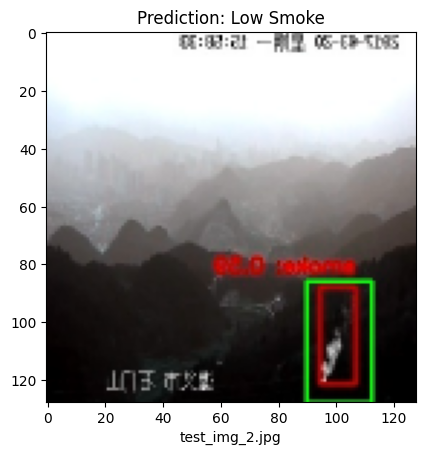

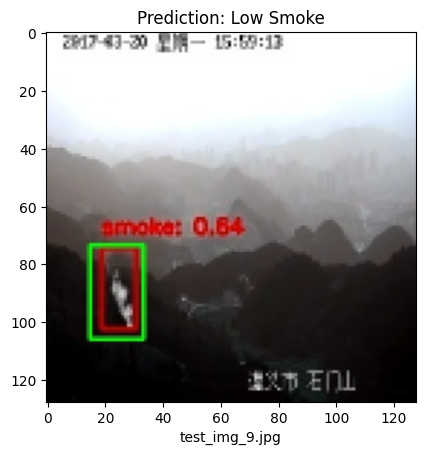

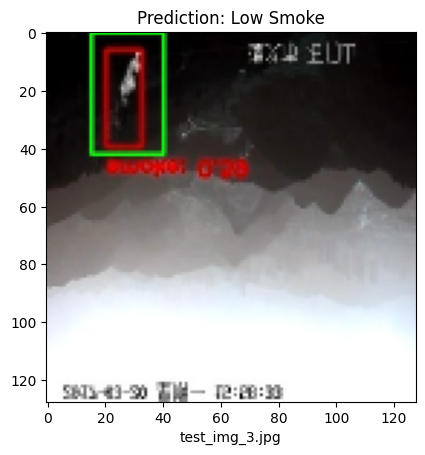

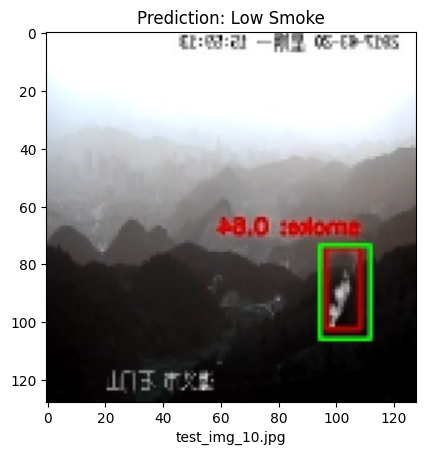

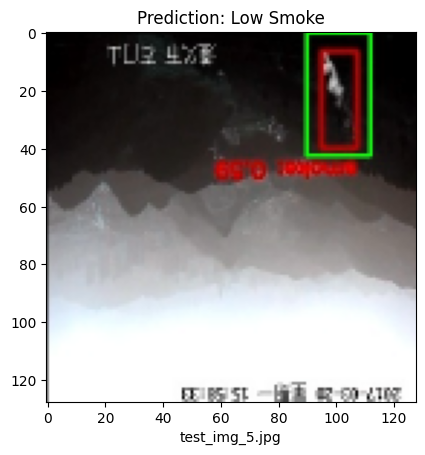

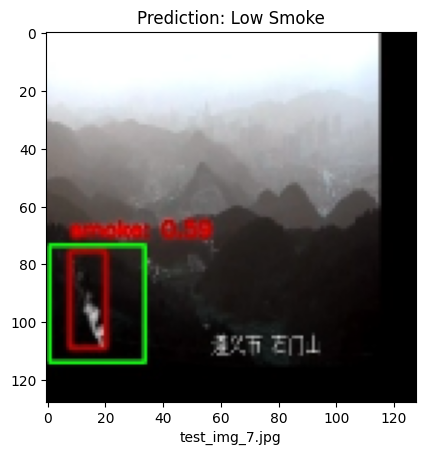

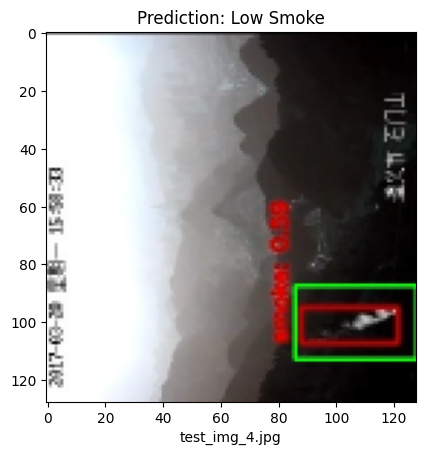

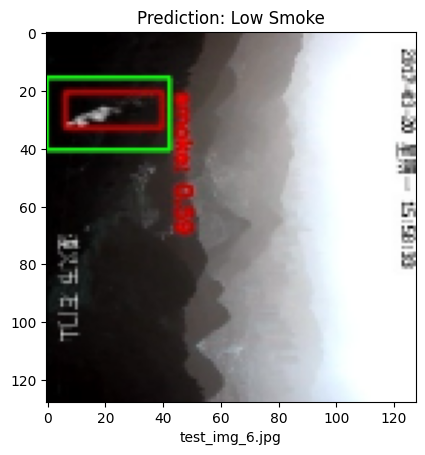

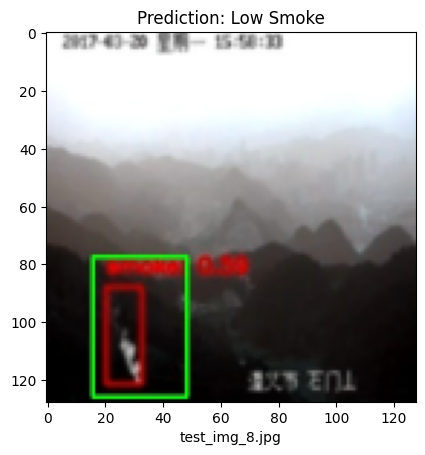

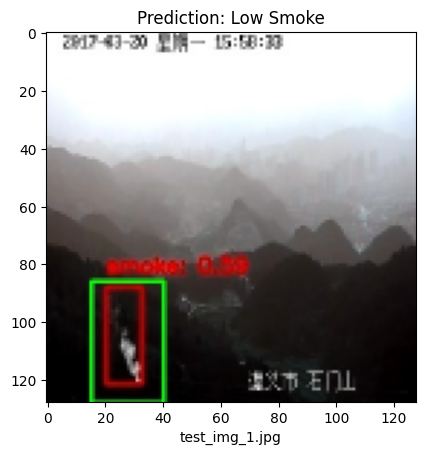

Image: test_img_2.jpg, Prediction: Low Smoke
Image: test_img_9.jpg, Prediction: Low Smoke
Image: test_img_3.jpg, Prediction: Low Smoke
Image: test_img_10.jpg, Prediction: Low Smoke
Image: test_img_5.jpg, Prediction: Low Smoke
Image: test_img_7.jpg, Prediction: Low Smoke
Image: test_img_4.jpg, Prediction: Low Smoke
Image: test_img_6.jpg, Prediction: Low Smoke
Image: test_img_8.jpg, Prediction: Low Smoke
Image: test_img_1.jpg, Prediction: Low Smoke


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Preprocess the image by resizing it to the required dimensions
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: {image_path} could not be read. Skipping this file.")
        return None
    roi = cv2.resize(image, (128, 128))  # Resize to 128x128
    return roi

# Load images from a specified folder
def load_images_from_folder(folder, num_images=10):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder, filename)
            roi = preprocess_image(image_path)
            if roi is not None:
                images.append(roi)
                filenames.append(filename)
            if len(images) == num_images:  # Stop after loading the required number of images
                break
    if len(images) < num_images:
        print(f"Warning: Only found {len(images)} out of {num_images} requested images.")
    return np.array(images), filenames

# Specify the input folder containing the unseen images
input_folder = '/content/test_images/test images'

# Load a specified number of unseen images
X_unseen, filenames_unseen = load_images_from_folder(input_folder, num_images=10)

# Check if any images were loaded
if len(X_unseen) == 0:
    raise ValueError("No images were loaded for prediction.")

# Normalize images
X_unseen = X_unseen / 255.0

# Load saved models
models = []
for i in range(3):
    model = load_model(f'/content/cnn_smoke_classification_model_{i}.h5')
    models.append(model)

# Make predictions with each model and average the results
predictions_unseen = [model.predict(X_unseen) for model in models]
avg_predictions_unseen = np.mean(predictions_unseen, axis=0)

# Convert averaged predictions to binary outputs
final_predictions_unseen = (avg_predictions_unseen > 0.5).astype(int)

# Display predictions for the unseen images
for i in range(len(filenames_unseen)):
    plt.figure()
    plt.imshow(X_unseen[i])
    plt.title(f"Prediction: {'High Smoke' if final_predictions_unseen[i] else 'Low Smoke'}")
    plt.xlabel(filenames_unseen[i])
    plt.show()

# Print the predictions
for filename, prediction in zip(filenames_unseen, final_predictions_unseen):
    print(f"Image: {filename}, Prediction: {'High Smoke' if prediction else 'Low Smoke'}")
